Business Problem: The company seeks to identify and prevent fraudulent transactions from a dataset to reduce financial losses.

Business Objective: Maximize accuracy

Business Constraints: Minimize fraud errors


Data Dictionary:

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

In [2]:
#Import dataset
df = pd.read_csv(r"C:\Users\senap\Downloads\Fraud.csv")
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
#Checking for missing values
df.isnull().values.any()

False

In [5]:
df.amount.describe()

count    6.362620e+06
mean     1.798619e+05
std      6.038582e+05
min      0.000000e+00
25%      1.338957e+04
50%      7.487194e+04
75%      2.087215e+05
max      9.244552e+07
Name: amount, dtype: float64

<Axes: xlabel='amount'>

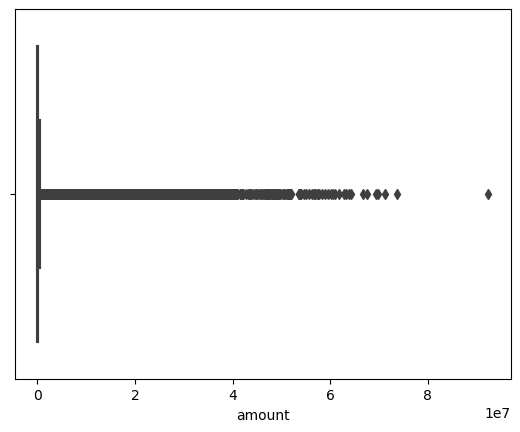

In [6]:
#Checking for Outliers
sns.boxplot(x=df['amount'])

<Axes: xlabel='amount'>

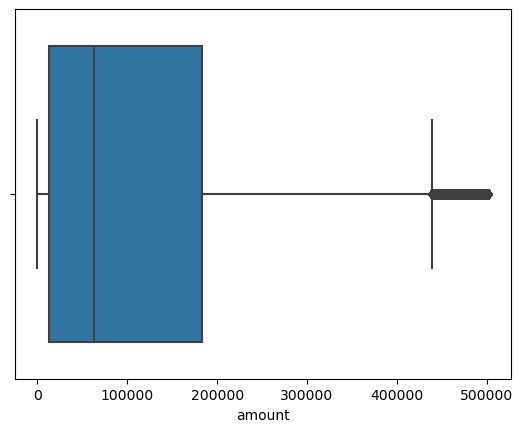

In [7]:
#Handling outliers
IQR = df['amount'].quantile(0.75) - df['amount'].quantile(0.25)

lower_limit = df['amount'].quantile(0.25) - (IQR * 1.5)
upper_limit = df['amount'].quantile(0.75) + (IQR * 1.5)

#Trimming
outliers_df = np.where(df['amount'] > upper_limit, True, np.where(df['amount'] < lower_limit, True, False))
sum(outliers_df)

df_out = df.loc[outliers_df, ]
df_trimmed = df.loc[~(outliers_df), ]
df.shape, df_trimmed.shape
#Explore outliers in the trimmed dataset
sns.boxplot(x = df_trimmed['amount'])

C:\Users\senap\AppData\Local\Temp\ipykernel_17388\3760735376.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


<Axes: >

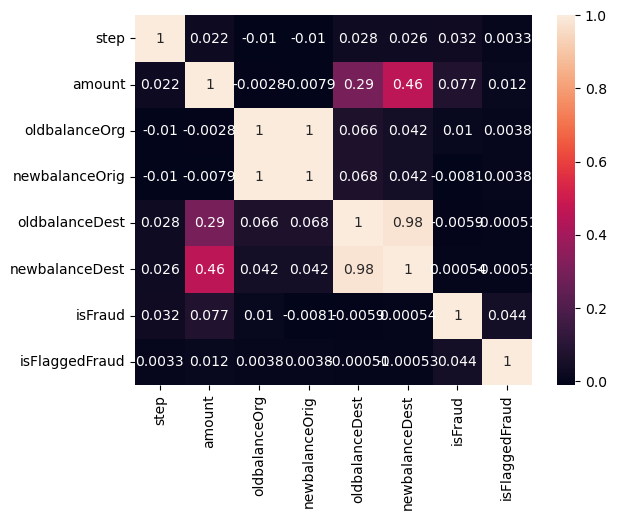

In [8]:
#Checking for multi collinearity
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot = True)

In [9]:
#oldbalanceOrg,newbalanceOrig, oldbalanceDest and newbalanceDest have strong correlation so we can drop them
df.drop(['oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest'], axis = 1, inplace = True)

In [10]:
df.columns

Index(['step', 'type', 'amount', 'nameOrig', 'nameDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

In [12]:
#Convert categorical data to numeric using one-hot encoding
df = pd.get_dummies(df, columns = ['type'], drop_first = True)
df

,step,amount,nameOrig,nameDest,isFraud,isFlaggedFraud,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,C1231006815,M1979787155,0,0,0,0,1,0
1,1,1864.28,C1666544295,M2044282225,0,0,0,0,1,0
2,1,181.00,C1305486145,C553264065,1,0,0,0,0,1
3,1,181.00,C840083671,C38997010,1,0,1,0,0,0
4,1,11668.14,C2048537720,M1230701703,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,339682.13,C786484425,C776919290,1,0,1,0,0,0
6362616,743,6311409.28,C1529008245,C1881841831,1,0,0,0,0,1
6362617,743,6311409.28,C1162922333,C1365125890,1,0,1,0,0,0
6362618,743,850002.52,C1685995037,C2080388513,1,0,0,0,0,1


Model Building

In [13]:
#Split the data
x = df.drop(['nameOrig', 'nameDest', 'isFraud', 'isFlaggedFraud'], axis = 1)
y = df['isFraud']

In [14]:
#Split the data into train and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

In [15]:
#Standardize numerical features
scaler = StandardScaler()
x_train[['amount']] = scaler.fit_transform(x_train[['amount']])
x_test[['amount']] = scaler.transform(x_test[['amount']])

In [16]:
#Different algorithms(eg:- Logistic Regression, Random Forest and XGBoost)
models = {'Logistic Regression': LogisticRegression(random_state = 42),
         'Random Forest': RandomForestClassifier(n_estimators = 100, random_state = 42),
         'XGBoost': XGBClassifier(random_state = 42, use_label_encoder = False, eval_metric = 'logloss')}


C:\Users\senap\anaconda3\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [17]:
#Initialize a result dataframe to store model performance metrics
results = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'ROC AUC'])

for model_name, model in models.items():
    model.fit(x_train, y_train)
    
    y_pred = model.predict(x_test)
    y_proba = model.predict_proba(x_test)[:, 1]
    
    #Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    #Results
    results = results.append({'Model': model_name,
                             'Accuracy': accuracy,
                             'Precision': precision,
                             'Recall': recall,
                             'F1 Score': f1,
                             'ROC AUC': roc_auc}, ignore_index = True)
print(results)

C:\Users\senap\AppData\Local\Temp\ipykernel_17388\3114041481.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,
C:\Users\senap\AppData\Local\Temp\ipykernel_17388\3114041481.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


                 Model  Accuracy  Precision    Recall  F1 Score   ROC AUC
0  Logistic Regression  0.998713   0.000000  0.000000  0.000000  0.894104
1        Random Forest  0.999070   0.803867  0.358522  0.495882  0.834742
2              XGBoost  0.999165   0.909533  0.383984  0.539994  0.973860


C:\Users\senap\AppData\Local\Temp\ipykernel_17388\3114041481.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({'Model': model_name,


Insights:

Logistic regression is clearly not performing well for this dataset due to imbalanced nature.
Random Forest is slightly better than Logistic regression.
XGBoost outperforms both Logistic Regression and Random Forest. It has the highest precision, F1 score and ROC AUC.


5- Key Factores tha predic fraudulan customers are amount and type of transaction.

6- Yes, these factors make sense. Unusual patterns in transaction amounts, transaction types are commonly associated with fraudulant activities.Certain transactions often raise red flags as they could be indicative of unauthorized access.

7- Prevention should be
 Fraud Detection Tools: Implement real-time anomaly detection systems that can flag suspicious activities as they occur.
 Encryption: Ensure strong encryption protocols for transactions and sensitive customer data.
 Multi-factore Authentication(MFA): Enforce MFA to reduce unauthorized access.
 Behavioral Monitoring: Implement systems that analyze customer behaviour patterns and flag anomalies.
 
8-Monitoring metrics: Track key performance metrics like fraud detection rate, false positives, and false negatives after implementing the system.
  Customer Feedback: Monitor customer complaints and feedback for signs of undetected fraud or improved security.